In [4]:
#Import libraries
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os

This image is: <class 'numpy.ndarray'> width dimensions: (540, 960, 3)


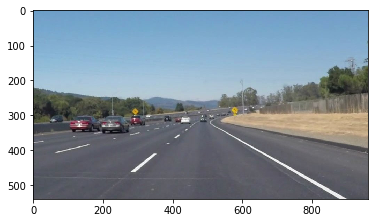

In [5]:
#Read in an image
image = mpimg.imread('images/solidwhiteCurve.jpg')

#Print some info about the image
print('This image is:', type(image), 'width dimensions:', image.shape)
plt.imshow(image)

In [6]:
def convertToGrayscale(img):
    """Applies the Grayscale transform
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny_detection(img, low_threshold, high_threshold):
    """
    Applies the Canny transform
    """
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """
    Applies a Gaussian Noise kernel
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.   
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def lane_finding(lines, img):
    """
    Applies mathematics basic line function to find the lane
    """
    lanes = [[], []]
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        #find the slope of a single line
        m = (y2 - y1) / (x2 - x1)
        
        #find the intercept of a single line
        b = y1 - (m * x1)
        
        if m > 0.4: #if the slope is greater than 0.4, it is the left lane side
            lanes[0].append([x1, y1, x2, y2])
        elif m < -0.4: #if the slope is smaller than 0.4, it is the right lane side
            lanes[1].append([x1, y1, x2, y2])
    return lanes

def lane_drawing(img, lane, color, thickness):
    """
    This function draws the lane detected
    """
    x1, y1, x2, y2 = [int(x) for x in lane]
    arr = np.array([(x1, y1), (x2, y2)], dtype=np.int32)
    [vx, vy, x, y] = cv2.fitLine(arr, cv2.DIST_L2, 0, 0.01, 0.01)
    slope = vy / vx
    intercept = y - (slope * x)
    y1 = int(img.shape[0])
    y2 = int(img.shape[0] * 0.6)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
def draw_lines(img, lines, color = [225, 10, 10], thickness = 5):
    """
    This function creates a line to detect the lane lines with red color and thickness = 5
    """
    for lane_lines in lane_finding(lines, img):
        averaged_lane = np.mean(lane_lines, axis = 0)
        lane_drawing(img, averaged_lane, color, thickness)
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn
    params:
        img: output of the Canny transform
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength = min_line_len, maxLineGap = max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, alpha = 0.8, beta = 1., gamma = 0.):
    """
    img: output of the hough_lines(), an image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    initial_img: image before any processing (original image).
    The result image is computed as follows: initial_img * alpha _ img * beta + gamma
    
    img and initial_img need to have same size
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

In [7]:
#Test images
test_images = ['images/{}'.format(filename) for filename in os.listdir("images/")]

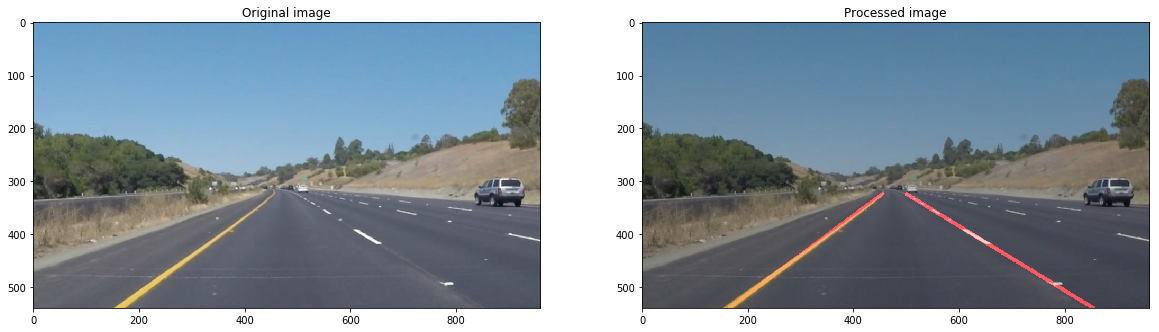

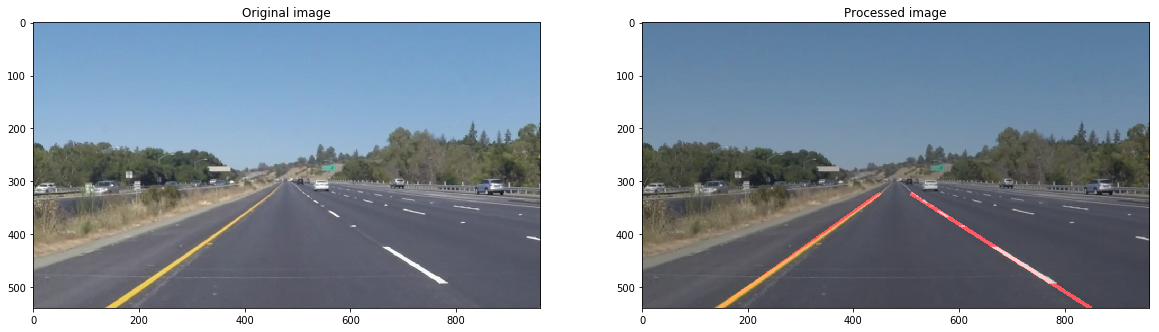

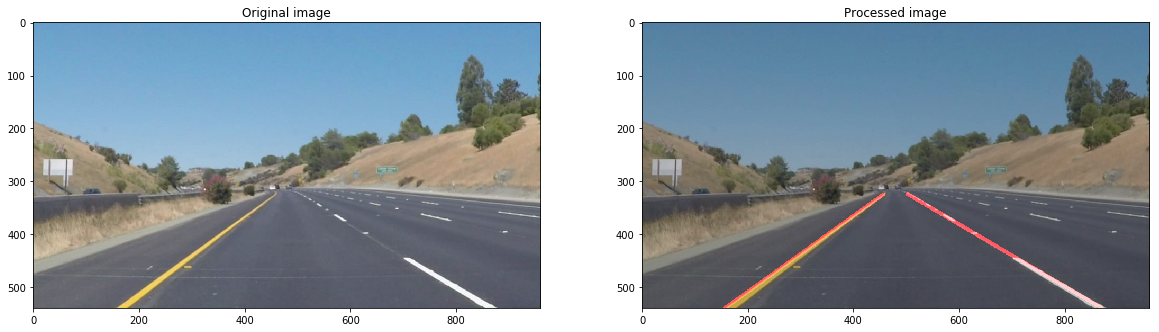

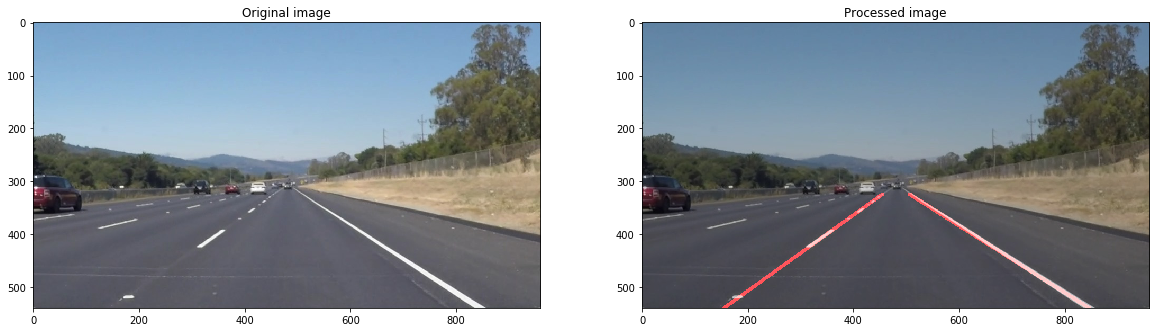

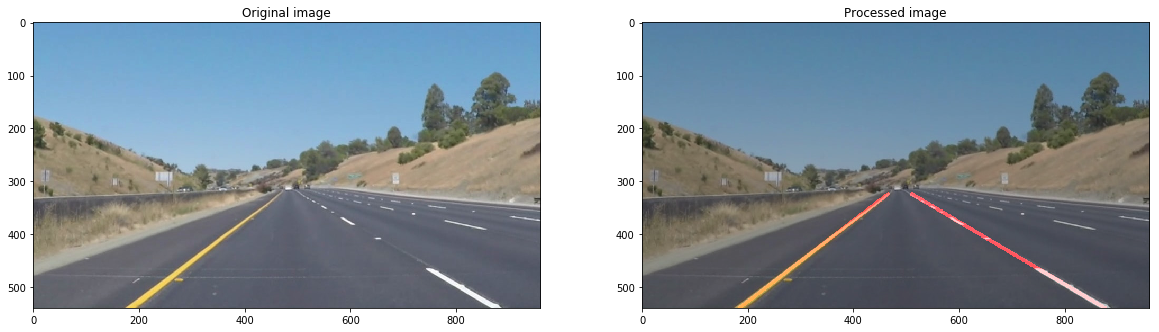

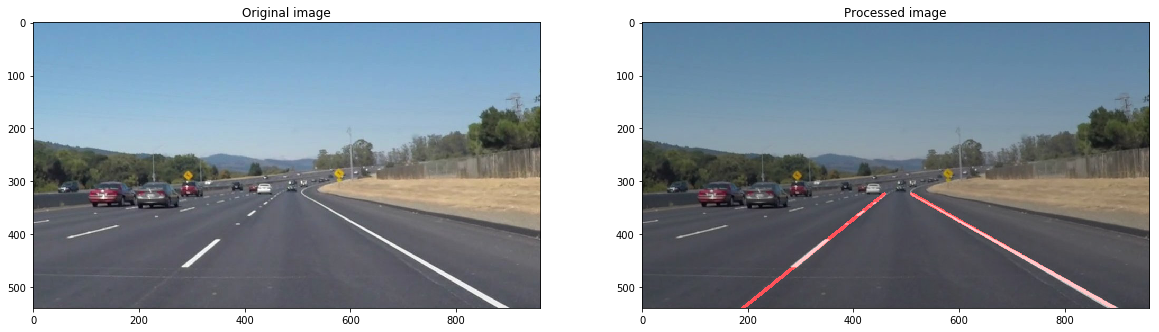

In [8]:
#Build a Lane Finding Pipeline
def show_img(origin, processed):
    """
    Shows original image and processed image
    """
    plt.figure(figsize = (20, 10))
    plt.subplot(121), plt.imshow(origin)
    plt.title('Original image')
    plt.subplot(122), plt.imshow(processed)
    plt.title('Processed image')
    plt.show()
    
def pipeline_detection(img, kernel_size = 5, canny_low = 60, canny_high = 150, rho = 1, theta = np.pi / 180, 
                      threshold = 40, min_line_len = 1, max_line_gap = 100):
    """
    Apply pipeline to display the detected lane lines in image
    """
    grayscale = convertToGrayscale(img)
    blur = gaussian_blur(grayscale, kernel_size)
    canny_edges = canny_detection(blur, canny_low, canny_high)
    vertices = np.array([[150, canny_edges.shape[0]],
                        [450, canny_edges.shape[0] * 0.5],
                        [500, canny_edges.shape[0] * 0.5],
                        [canny_edges.shape[1], canny_edges.shape[0]]], np.int32)
    roi = region_of_interest(canny_edges, [vertices])
    h_lines = hough_lines(roi, rho, theta, threshold, min_line_len, max_line_gap)
    final_img = weighted_img(h_lines, img)
    return final_img

for img_name in test_images:
    img = mpimg.imread(img_name)
    lane_detected_imgs = pipeline_detection(img)
    show_img(img, lane_detected_imgs)

In [10]:
#Test on Videos
#import libraries needed for edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(img):
    """ Return a color image for processing video
    """
    return pipeline_detection(img)

In [14]:
test_vid1 = './video_output/solidWhiteRight.mp4'

clip1 = VideoFileClip("./videos/solidWhiteRight.mp4")
output_clip1 = clip1.fl_image(process_image)
%time output_clip1.write_videofile(test_vid1, audio = False)

t:   5%|▌         | 12/221 [00:00<00:01, 114.59it/s, now=None]

Moviepy - Building video ./video_output/solidWhiteRight.mp4.
Moviepy - Writing video ./video_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready ./video_output/solidWhiteRight.mp4
CPU times: user 1.62 s, sys: 166 ms, total: 1.78 s
Wall time: 4.1 s


In [15]:
HTML("""
<video width="900" height="500" controls>
  <source src="{0}">
</video>
""".format(test_vid1))

In [16]:
test_vid2 = './video_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('./videos/solidYellowLeft.mp4')
output_clip2 = clip2.fl_image(process_image)
%time output_clip2.write_videofile(test_vid2, audio=False)

t:   2%|▏         | 14/681 [00:00<00:04, 139.53it/s, now=None]

Moviepy - Building video ./video_output/solidYellowLeft.mp4.
Moviepy - Writing video ./video_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready ./video_output/solidYellowLeft.mp4
CPU times: user 5.36 s, sys: 502 ms, total: 5.86 s
Wall time: 13.2 s


In [17]:
HTML("""
<video width="900" height="500" controls>
  <source src="{0}">
</video>
""".format(test_vid2))

In [19]:
test_vid3 = './video_output/challenge.mp4'
clip3 = VideoFileClip('./videos/challenge.mp4')
output_clip3 = clip3.fl_image(process_image)
%time output_clip2.write_videofile(test_vid3, audio=False)

t:   1%|▏         | 9/681 [00:00<00:07, 88.77it/s, now=None]

Moviepy - Building video ./video_output/challenge.mp4.
Moviepy - Writing video ./video_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready ./video_output/challenge.mp4
CPU times: user 5.35 s, sys: 490 ms, total: 5.84 s
Wall time: 13.4 s


In [20]:
HTML("""
<video width="900" height="500" controls>
  <source src="{0}">
</video>
""".format(test_vid3))